### Theoretical Backgrounds

A sparse autoencoder is a type of neural networks whose aim is to successfully _reconstruct_ a given input. Therefore, unlike the neural networks we used for regression or classification tasks, when we design an autoencoder, we have an identical dimension for our input and output layers.

Sparse autoencoders consist of two parts: an encoder and a decoder. An encoder receives inputs and "compress" them in lower dimensional space, so called _latent space_. A decoder then uses this representation in the latent space to successfully reconstruct the original input. Normally an encoder and a decoder have symmetrical structure, although it is not mandatory. 

### Reconstructing MNIST images

In [1]:
# Load libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

import tqdm

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")


We now load the data. Because the MNIST dataset is quite large, we import only the training dataset, which consists of 60000 images.

In [2]:
# Load MNIST dataset

mnist_dataset = MNIST(
    root='../../data',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)
mnist_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../../data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [3]:
mnist_dataset.data.shape

torch.Size([60000, 28, 28])

In [4]:
# flatten the images
X_data = mnist_dataset.data.view(-1, 28*28)
X_data.shape

torch.Size([60000, 784])

In [6]:
# Check if the data is normalized
X_data[0].min(), X_data[0].max()

(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

In [7]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_data, 
    mnist_dataset.targets, 
    test_size=0.2, 
    random_state=42,
)

# scale the data (X_train and X_test become numpy arrays)
scaler = Normalizer()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (48000, 784)
X_test.shape: (12000, 784)
y_train.shape: torch.Size([48000])
y_test.shape: torch.Size([12000])


In [9]:
batch_size = 128
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=False)

In [10]:
# Design a sparse autoencoder

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.fc4 = nn.Linear(hidden_dims[2], latent_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dims, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dims[2])
        self.fc2 = nn.Linear(hidden_dims[2], hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[0])
        self.fc4 = nn.Linear(hidden_dims[0], output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [11]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dims, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dims, input_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [16]:
input_dim = X_train.shape[1]
hidden_dims = [256, 128, 64]
latent_dim = 32
lr = 1e-3
num_epochs = 30

autoencoder = Autoencoder(input_dim=input_dim, hidden_dims=hidden_dims, latent_dim=latent_dim).to(device)
autoencoder

Autoencoder(
  (encoder): Encoder(
    (fc1): Linear(in_features=784, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=64, bias=True)
    (fc4): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=32, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=256, bias=True)
    (fc4): Linear(in_features=256, out_features=784, bias=True)
  )
)

In [17]:
# Train the autoencoder

optimizer = optim.Adam(autoencoder.parameters(), lr=lr)
criterion = nn.MSELoss()

loss_history = []

bar_format = '{l_bar}{bar:10}| {n:4}/{total_fmt} [{elapsed:>7}<{remaining:>7}, {rate_fmt}{postfix}]'
progress_bar = tqdm.trange(num_epochs, unit="ep", bar_format=bar_format, ascii=True)

for i in progress_bar:

    total_loss = 0
    for i, x in enumerate(train_loader):
        inputs = x.type(torch.float32).to(device)
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
        loss_history.append(loss.item())
    loss_avg = np.mean(loss_history)

    progress_bar.set_postfix_str(f"Loss: {total_loss}, avg loss: {loss_avg}")
progress_bar.update(0)

100%|##########|   30/30 [  00:57<  00:00,  1.92s/ep, Loss: 0.05128795371274464, avg loss: 0.00019929044457514666] 


In [18]:
autoencoder.eval()

with torch.no_grad():
    for batch_idx, x in enumerate(tqdm.tqdm(test_loader)):
        x = x.type(torch.float32).to(device)
        x_hat = autoencoder(x)
        break

  0%|          | 0/94 [00:00<?, ?it/s]


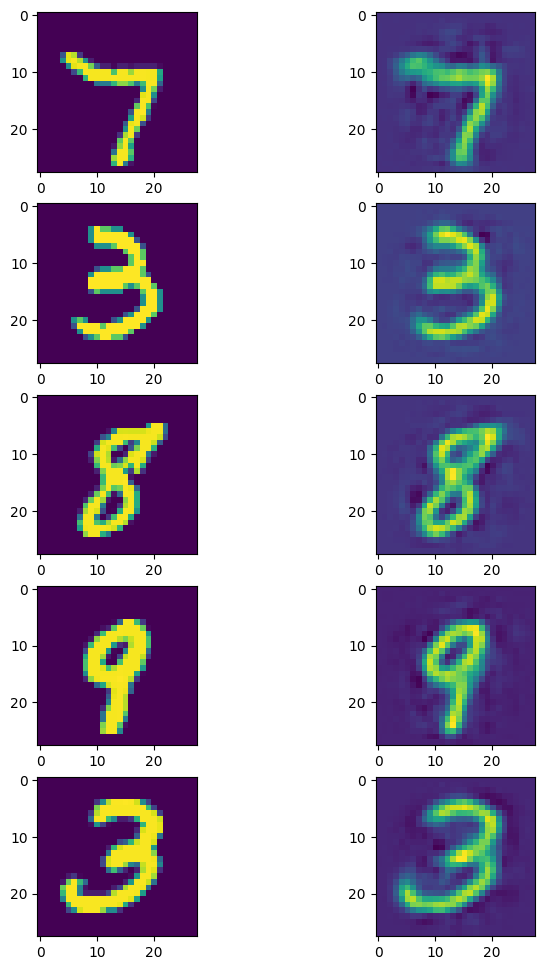

In [19]:
def compare_results(x, x_hat, n):
    x = x.view(batch_size, 28, 28)
    x_hat = x_hat.view(batch_size, 28, 28)

    fig = plt.figure(figsize=(8, 12))
    for i in range(n):
        plt.subplot(n, 2, 2*i+1)
        plt.imshow(x[i].cpu().numpy())
        plt.subplot(n, 2, 2*i+2)
        plt.imshow(x_hat[i].cpu().numpy())

    plt.show()
    # fig.savefig('./samples/vae-results.png')

compare_results(x, x_hat, 5)

### Dimensionality reduction 